# RoadRunner ODE integration with django database

For large-scale and large model simulations the simulation data and definition have to be stored in a persistant way. For this all definitions and simulations are managed via a Django database backend.  
Tasks, simulations, parameters and timecourses are easily managable via the common database backend.
`django.setup`
http://localhost:8000/simapp/

## Python and module versions

Since there are several different versions of Python and each Python package has its own release cycle and version number (for example scipy, numpy, matplotlib, etc., which we installed above and will discuss in detail in the following lectures), it is important for the reproducibility of an IPython notebook to record the versions of all these different software packages. If this is done properly it will be easy to reproduce the environment that was used to run a notebook, but if not it can be hard to know what was used to produce the results in a notebook.

To encourage the practice of recording Python and module versions in notebooks, I've created a simple IPython extension that produces a table with versions numbers of selected software components. I believe that it is a good practice to include this kind of table in every notebook you create.

To install this IPython extension, run:

In [84]:
# you only need to do this once
%install_ext http://raw.github.com/jrjohansson/version_information/master/version_information.py

Installed version_information.py. To use it, type:
  %load_ext version_information


In [85]:
%load_ext version_information
%version_information numpy, scipy, matplotlib, sympy, pandas, django, roadrunner, libsbml

The version_information extension is already loaded. To reload it, use:
  %reload_ext version_information


Software,Version
Python,2.7.6 64bit [GCC 4.8.2]
IPython,3.1.0
OS,Linux 3.13.0 43 generic x86_64 with Ubuntu 14.04 trusty
numpy,1.8.2
scipy,0.13.3
matplotlib,1.3.1
sympy,0.7.4.1
pandas,0.16.1
django,1.8.1
roadrunner,roadrunner


## Simulations based on database
### Database setup

In [86]:
# import and setup database
import django
django.setup()

In [87]:
# import the database API functions and tools
import simapp.db.api as db_api
import odesim.db.tools as db_tools

In [88]:
# display the backend used
from django.conf import settings
print settings.SETTINGS_MODULE

multiscalesite.settings


## Create model from given filepath

Load one of the demo model provided in examples and create the model in the database.  
Model creation and interaction with models is simplified via the `db_api` module.

In [89]:
# create model in database
from examples.testdata import demo_filepath
print(demo_filepath)
comp_model = db_api.create_model(filepath=demo_filepath)

/home/mkoenig/multiscale-galactose/python/multiscalesite/examples/demo/Koenig_demo_v02.xml


The model is now in the database and can be accessed.  
For instance get the primary database key, the stored filepath on the database server or the MD5 hash of the model which uniquely defines the model version used. Via the MD5 hash the model version is clearly specified.

In [90]:
# Print some information about the model
print 'pk:', comp_model.pk
print 'filepath:', comp_model.filepath
print 'MD5:', comp_model.md5

pk: 55
filepath: /home/mkoenig/multiscale-galactose-results/django/model/Koenig_demo_v02.xml
MD5: c35ba1642554c764a65cd965aebe7afa


With the model key we can lookup all the information in the database and for instance create a human readable report of the model. Open the database and navigate to the models.  
http://localhost:8000/simapp/

## Simulation

We can now define tasks for the model. A task is a collection of simulations with identical settings. One can imagine them as a set of comparable simulations with different parameters or initial concentrations. 

In this example we use RoadRunner for the numerical integrations.

In [91]:
# TODO: update RoadRunner to latest version (should be 1.3.2)
import roadrunner
print(roadrunner.getVersionStr())

1.3; Compiler: gcc 4.6.3, C++ version: 1; JIT Compiler: LLVM-3.4; Date: Jan 12 2015, 16:43:38


Like before we can define single simulations with the SBML model based on the filepath of the model. 
This is only using the file information from the SBMLModel but does not create actual Tasks, Simulations or Timecourses in the database. 

See below how for detailled example for the creation.

['time', '[A]', '[B]', '[C]', '[A_ext]', '[B_ext]', '[C_ext]']


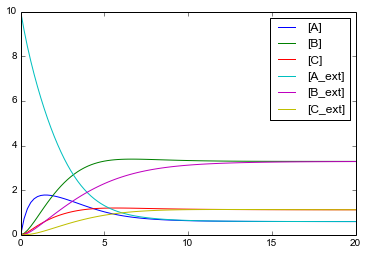

In [92]:
%matplotlib inline
# Uset the filepath from the database
rr = roadrunner.RoadRunner(comp_model.filepath)
print rr.selections
s = rr.simulate(0,20, 100, plot=True)  # equidistant timecourse for 20 [s]

Now we perform the same simulation via the database and store the results and plots we generate in the database.
Create parameters and initial concentrations for simulation and setup a task for the simulation.  
In a first step single simulations are run based on given changes to the model.

### Parameters for simulation

Define the parameters and pack all parameters for the simulation in the sample

In [93]:
reload(db_api)

<module 'simapp.db.api' from '/home/mkoenig/multiscale-galactose/python/multiscalesite/simapp/db/api.pyc'>

The following `ParameterType` can be set for individual simulations
* GLOBAL_PARAMETER : set a parameter in the model
* BOUNDARY_INIT : set a initial boundary species concentration (boundary species are constant throughout the simulation)
* FLOATING_INIT : set a initial floating species concentration (floating species are not constant)
* NONE_SBML_PARAMETER : parameter not influencing the simulation, but stored with the parameter set

In [94]:
db_api.ParameterType.labels

{1: 'GLOBAL_PARAMETER',
 2: 'BOUNDARY_INIT',
 3: 'FLOATING_INIT',
 4: 'NONE_SBML_PARAMETER'}

A single simulation is based on a sample of parameters, i.e. a collection of parameters.
In our example we are interested in a single simulation setting a `Vmax` value and changing an initial concentration.

In [95]:
from odesim.dist.samples import Sample, SampleParameter
# create an empty sample (this would just run the simulation with the defined parameters and concentrations)
s = Sample()

# Change the Vmax of b1 (Vmax_b1)
sp1 = SampleParameter('Vmax_bA', 5.0, unit='mole_per_s', parameter_type=db_api.ParameterType.GLOBAL_PARAMETER)
# Change the initial concentration of A
sp2 = SampleParameter('A', 7.0, unit='mM', parameter_type=db_api.ParameterType.FLOATING_INIT)
# Add the parameters to the sample
s.add_parameters([sp1, sp2])

print type(s), s

<class 'odesim.dist.samples.Sample'> {'A': <A = 7.000E+00 [mM] (FLOATING_INIT)>, 'Vmax_bA': <Vmax_bA = 5.000E+00 [mole_per_s] (GLOBAL_PARAMETER)>}


### Simulation method

Based on this sample we now create a simulation.  

Define with which method and settings the model should be simulated. In this case we want and ODE integration with given start and end time and number of steps.

In [96]:
db_api.SettingKey.labels

{1: 'INTEGRATOR',
 2: 'VAR_STEPS',
 3: 'ABS_TOL',
 4: 'REL_TOL',
 5: 'T_START',
 6: 'T_END',
 7: 'STEPS',
 8: 'STIFF',
 9: 'MIN_TIME_STEP',
 10: 'MAX_TIME_STEP',
 11: 'MAX_NUM_STEP'}

In [97]:
# We want step based integration in the interval [0.0, 20.0]
settings_dict = {db_api.SettingKey.VAR_STEPS: False,\
                 db_api.SettingKey.T_START: 0.0,\
                 db_api.SettingKey.T_END: 20.0, \
                 db_api.SettingKey.STEPS: 100}

# For the tolerances, ... we use the default settings
settings = db_api.create_settings(settings_dict)
for setting in settings:
    print(setting)

INTEGRATOR = ROADRUNNER
VAR_STEPS = False
ABS_TOL = 1e-06
REL_TOL = 1e-06
T_START = 0.0
T_END = 20.0
STEPS = 100
STIFF = True


With the settings we create the method for solving our computational model. In this case we are interested in an ODE solution of the network. The settings and the actual method for simulation are tightly connected.

In [98]:
db_api.MethodType.labels

{1: 'ODE', 2: 'FBA'}

In [99]:
method = db_api.create_method(method_type=db_api.MethodType.ODE, settings=settings)
method.pk

58

### Task

The next step is defining a task for all our simulations. We only have one simulation so far, but the concept of tasks becomes much clearer in the context of many simulations under varying simulation settings.

In [100]:
task = db_api.create_task(comp_model, method=method, info="Single database demo simulation.")
task.pk
task.method.method_type

1

### Simulations

Now we create the actual simulations from the samples.

In [101]:
samples = [s]
simulations = db_tools.create_simulations_from_samples(task, samples)
print('samples:', samples)
print('simulations:', simulations)
# Simulations are not unique in respect to the parameters. 
# Adding the same simulation multiple times to a task is possible.

('samples:', [{'A': <A = 7.000E+00 [mM] (FLOATING_INIT)>, 'Vmax_bA': <Vmax_bA = 5.000E+00 [mole_per_s] (GLOBAL_PARAMETER)>}])
('simulations:', [<Simulation: S408>])


In [39]:
# We can see the simulations from the simulation set of the task.
task.simulations.all()

[<Simulation: S15>, <Simulation: S16>, <Simulation: S17>, <Simulation: S28>, <Simulation: S349>, <Simulation: S350>]

In [40]:
reload(db_api)

<module 'simapp.db.api' from '/home/mkoenig/multiscale-galactose/python/multiscalesite/simapp/db/api.pyc'>

### Solve the ODE system

Now we are running the solver on the defined problems.

In [41]:
from odesim.simulate import solve
reload(solve)

<module 'odesim.simulate.solve' from '/home/mkoenig/multiscale-galactose/python/simulator/odesim/simulate/solve.pyc'>

In [42]:
# Run the actual simulations    
print('* Start integration *')
print('Simulation: ', simulations)

solve.run_simulations(simulations, task)

* Start integration *
('Simulation: ', [<Simulation: S350>])
Loading : /home/mkoenig/multiscale-galactose-results/django/model/Koenig_demo_v02.xml
SBML load time : 0.038743019104
/home/mkoenig/multiscale-galactose-results/tmp_sim/T43/Koenig_demo_v02_S350_roadrunner.h5
HDF5: 0.0276420116425
Time: [0.047|0.008 |17.55]


In [43]:
# Load the HDF5 file results
from simapp.models import Result
reload(db_api)

<module 'simapp.db.api' from '/home/mkoenig/multiscale-galactose/python/multiscalesite/simapp/db/api.pyc'>

In [70]:
# Get the first simulation result 
simulations[0].pk
results = Result.objects.filter(simulation=simulations[0], result_type=db_api.ResultType.HDF5)
print results
r1 = results[0]
h5_filepath = str(r1.file.path)
h5_filepath

[<Result: R125 (hdf5)>]


'/home/mkoenig/multiscale-galactose-results/django/result/T43/Koenig_demo_v02_S350_roadrunner.h5'

In [71]:
# Load the HDF5 file
from odesim.simulate import solve_io
reload(solve_io)
data, header = solve_io.load_hdf5(h5_filepath)

In [72]:
# Visualize the results
from pandas import DataFrame
df = DataFrame(data, columns=header)
print df.head()
print len(df)
# TODO: fix bug - var steps not used

           time       [A]           [B]           [C]    [A_ext]  \
0  0.000000e+00  7.000000  0.000000e+00  0.000000e+00  10.000000   
1  2.999259e-09  7.000000  2.099482e-08  1.049741e-08  10.000000   
2  2.999559e-05  6.999710  2.099347e-04  1.049766e-04   9.999975   
3  3.299215e-04  6.996812  2.306783e-03  1.154103e-03   9.999725   
4  6.298475e-04  6.993916  4.400598e-03  2.202517e-03   9.999474   

        [B_ext]       [C_ext]  
0  0.000000e+00  0.000000e+00  
1  2.518756e-16  2.098963e-17  
2  2.517235e-08  2.098897e-09  
3  1.944023e-06  1.628567e-07  
4  6.067680e-06  5.097557e-07  
141


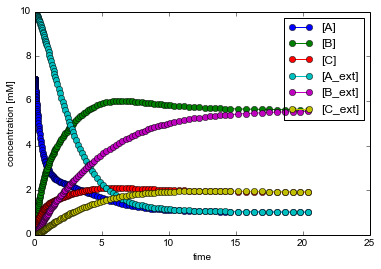

In [79]:
import matplotlib.pylab as plt
time = df['time']
for k in xrange(1, len(df.columns)):
    name = df.columns[k]
    plt.plot(df['time'], df[name], '-o', label=name)
plt.legend()
plt.xlabel('time')
plt.ylabel('concentration [mM]')
savepath = '/home/mkoenig/multiscale-galactose-results/django/result/T43/Koenig_demo_v02_S350_roadrunner.png'
plt.savefig(savepath)

In [78]:
# create a plotfile
simulations[0]


In [83]:
# Store the plot as result
reload(solve_io)
solve_io.store_result_db(simulation=simulations[0], filepath=savepath, result_type=db_api.ResultType.PNG)

## Distribution of parameters
Define distributions of parameters and sample from them.

Perform the same workflow for a whole set of simulations. 
Create visualizations for the individual results as well as for the task.
Handle via hash -> if simulations change, the plots have to be recalculated.

['time', '[A_in]', '[B_in]', '[C_in]', '[A_out]', '[B_out]', '[C_out]']


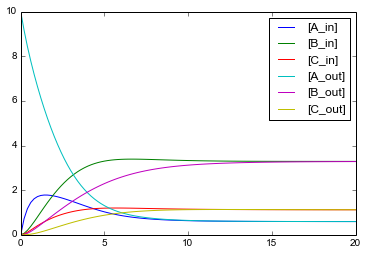

In [15]:
# TODO
%matplotlib inline
rr = roadrunner.RoadRunner('Koenig_demo.xml')
print rr.selections
s = rr.simulate(0,20, 100, plot=True)  # equidistant timecourse for 20 [s]

In [ ]:
# TODO: create simulations for parameter distributions

## HDF5 file storage
For large scale simulations the data has to be stored efficiently in files (HDF5).
Binary file format.